In [1]:
import sys
import os.path
import pylab as plt
path = '../'
sys.path.append(path)
from zedstat.zedstat import zedstat
import pandas as pd

In [2]:
df=pd.read_csv('examples_data/roc2.csv')
df=df.sort_values('fpr')
#df=df.drop('threshold',axis=1)

In [3]:
IST=istat(df=df,order=3,total_samples=100000,positive_samples=1000,alpha=0.1,prevalence=.01)

In [4]:
IST.smooth(STEP=0.001)
IST.convexify()
IST.allmeasures(interpolate=True)
IST.correctPPV()
IST.usample(precision=3)
IST.cb_delta()
IST.getUL(direction='L')
IST.getUL(direction='U')

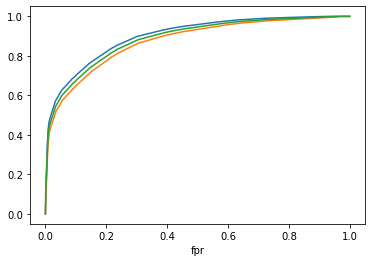

In [5]:
ax=IST.df_lim['U'].tpr.plot()
ax=IST.df_lim['L'].tpr.plot(ax=ax)
ax=IST.get().tpr.plot(ax=ax)


In [6]:
wf=IST.get()

<AxesSubplot:xlabel='LR-'>

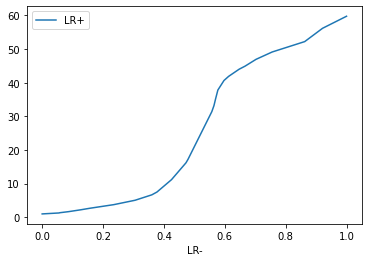

In [7]:
wf.plot(x='LR-',y='LR+')

In [8]:
IST.operating_zone(LRminus=.65)

,fpr,tpr,ppv,acc,npv,LR+,LR-,threshold
high precision,0.008,0.358115,0.307628,0.985499,0.993506,43.99784,0.647145,0.234186
high sensitivity,0.064,0.616202,0.091559,0.932393,0.995877,10.00695,0.409831,0.031257


In [9]:
#IST.auc()
IST.auc_cb2()

In [10]:
IST.auc()

{'L': 0.8738887723569924,
 'U': 0.9011943034492365,
 'nominal': 0.8875903790087464,
 'auc_L': 0.8721951632227701,
 'auc_U': 0.9050772210346357}

In [11]:
IST.interpret(fpr=0.008,number_of_positives=100)

,pos,flags,tp,fp,fn,tn
numbers,100,258,47,211,53,10000


In [14]:
IST.samplesize(delta_auc=.1)

26.99420757849582

<AxesSubplot:>

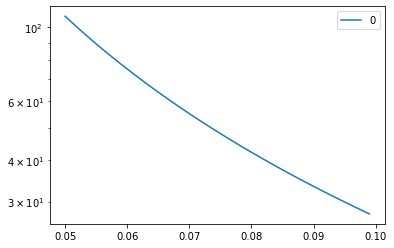

In [22]:
import numpy as np
pd.DataFrame(np.array([IST.samplesize(delta_auc=a) 
                       for a in np.arange(.05,.1,.001)]),
             np.arange(.05,.1,.001)).plot(logy=True)